In [1]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import madrigalWeb.madrigalWeb
import re
import h5py
import numpy as np

In [2]:
#CHANGE ME
user_fullname = "Student Example"
user_email = "isr.summer.school@gmail.com"
user_affiliation = "ISR Summer School 2020"

maddat = madrigalWeb.madrigalWeb.MadrigalData('http://isr.sri.com/madrigal/')

In [3]:
#instrument codes for AMISR
instcodes={'PFISR':61,
          'RISR-N':91,
          'RISR-C':92}

In [4]:
#start time
st=datetime.datetime(2018,12,22,0,0,0)
et=datetime.datetime(2018,12,23,0,0,0)
expList = maddat.getExperiments(instcodes['PFISR'], st.year, st.month, st.day, st.hour, st.minute, st.second, et.year, et.month, et.day, et.hour, et.minute, et.second)
for exp in expList:
    print(exp)

id: 30009907
realUrl: http://isr.sri.com/madrigal/cgi-bin/madExperiment.cgi?exp=2018/pfa/21dec18h&displayLevel=0&expTitle=IPY27_Tracking_v03+-+Long+duration+measurements+in+support+of+the+International+Polar+Year
url: http://isr.sri.com/madrigal/cgi-bin/madtoc/2018/pfa/21dec18h
name: IPY27_Tracking_v03 - Long duration measurements in support of the International Polar Year
siteid: 3
sitename: SRI
instcode: 61
instname: Poker Flat IS Radar
startyear: 2018
startmonth: 12
startday: 21
starthour: 14
startmin: 1
startsec: 1
endyear: 2018
endmonth: 12
endday: 22
endhour: 4
endmin: 20
endsec: 4
isLocal: True
madrigalUrl: http://isr.sri.com/madrigal
PI: unknown
PIEmail: unknown
uttimestamp: None
access: None
Madrigal version: 2.6.2

id: 30009945
realUrl: http://isr.sri.com/madrigal/cgi-bin/madExperiment.cgi?exp=2018/pfa/22dec18a&displayLevel=0&expTitle=MSWinds26.v03+-+D-region+E-region+F-region+local+measurements
url: http://isr.sri.com/madrigal/cgi-bin/madtoc/2018/pfa/22dec18a
name: MSWinds26

In [5]:
print(expList[4])

id: 30009948
realUrl: http://isr.sri.com/madrigal/cgi-bin/madExperiment.cgi?exp=2018/pfa/22dec18h&displayLevel=0&expTitle=PLCal30+-+Plasma+line+calibration+run
url: http://isr.sri.com/madrigal/cgi-bin/madtoc/2018/pfa/22dec18h
name: PLCal30 - Plasma line calibration run
siteid: 3
sitename: SRI
instcode: 61
instname: Poker Flat IS Radar
startyear: 2018
startmonth: 12
startday: 22
starthour: 18
startmin: 0
startsec: 49
endyear: 2018
endmonth: 12
endday: 23
endhour: 0
endmin: 0
endsec: 4
isLocal: True
madrigalUrl: http://isr.sri.com/madrigal
PI: unknown
PIEmail: unknown
uttimestamp: None
access: None
Madrigal version: 2.6.2



In [6]:
fileList = maddat.getExperimentFiles(expList[4].id)
lpfile=None
for file in fileList:
    if re.match('Long Pulse Uncorrected Ne',file.kindatdesc):
        lpfile=file
        
filename=lpfile.name
outfilename=lpfile.name.split('/')[-1]
result = maddat.downloadFile(filename, outfilename, user_fullname, user_email, user_affiliation, 'hdf5')

In [7]:
with h5py.File(outfilename,'r') as f:
    PFISR_data = []
    for dat in f['Data/Array Layout'].values():
        outdct={}
        outdct['bid'] = dat['1D Parameters/beamid'][0]
        outdct['azm'] = dat['1D Parameters/azm'][0]
        outdct['elm'] = dat['1D Parameters/elm'][0]
        outdct['ne'] = 10**(dat['2D Parameters/popl'][:])
        outdct['dne'] = 10**(dat['2D Parameters/dpopl'][:])
        
        outdct['range'] = dat['range'][:]
        outdct['altitude'] = outdct['range']*np.sin(np.radians(outdct['elm']))
        tstmp = dat['timestamps'][:]
        outdct['time'] = [datetime.datetime.utcfromtimestamp(t) for t in tstmp]
        PFISR_data.append(outdct)

In [8]:
for i,d in enumerate(PFISR_data):
    print(d['bid'],d['azm'],d['elm'])

64016.0 14.04 90.0
64112.0 -154.3 84.5
64124.0 -154.3 80.5
64157.0 -154.3 77.5
64982.0 15.0 74.0
65162.0 15.0 83.0


In [9]:
#find the vertical beam and a down-range beam to the north
bind=0
for i,d in enumerate(PFISR_data):
    if d['elm']==90.0:
        bind=i
bdat=PFISR_data[bind]

bdown=0
for i,d in enumerate(PFISR_data):
    if d['elm']==74.0:
        bdown=i
downdat=PFISR_data[bdown]

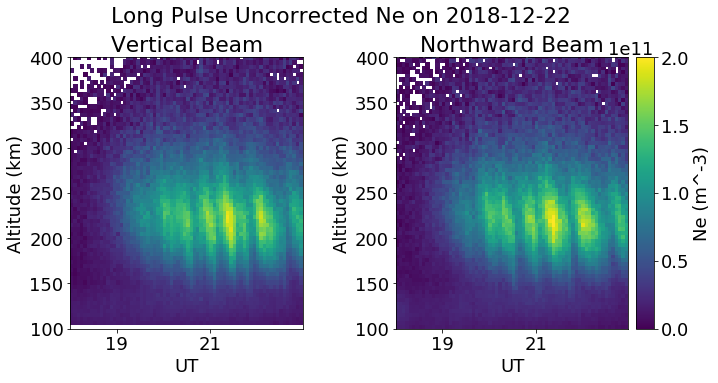

In [10]:
plt.rcParams['figure.figsize']=10,5
plt.rcParams['font.size']=18
fig,axarr=plt.subplots(1,2)
fig.subplots_adjust(wspace=0.4)

clrs = axarr[0].pcolormesh(mdates.date2num(bdat['time']),bdat['altitude'],bdat['ne'],vmin=0,vmax=2e11)

axarr[0].set_ylim([100,400])

axarr[0].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
axarr[0].set_xlabel('UT')
axarr[0].set_ylabel('Altitude (km)')
axarr[0].set_title('Vertical Beam')

fig.suptitle('Long Pulse Uncorrected Ne on 2018-12-22',y=1.02)

clrs = axarr[1].pcolormesh(mdates.date2num(downdat['time']),downdat['altitude'],downdat['ne'],vmin=0,vmax=2e11)

axarr[1].set_ylim([100,400])

axarr[1].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
axarr[1].set_xlabel('UT')
axarr[1].set_ylabel('Altitude (km)')
axarr[1].set_title('Northward Beam')

box=axarr[-1].get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
cb.set_label('Ne (m^-3)')

Text(0.5, 1.0, 'Electron Densities at 220 km')

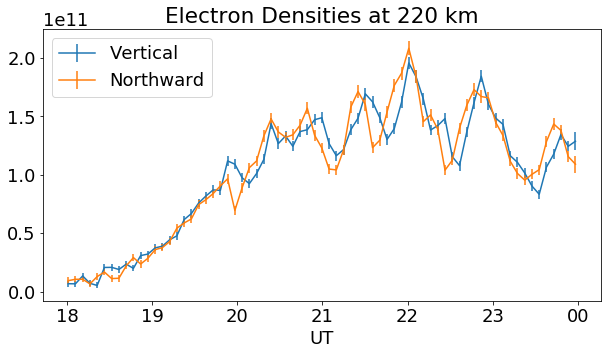

In [11]:
#overplot a slices at 220 km
a220v=np.argmin(np.abs(bdat['altitude']-220))

a220d=np.argmin(np.abs(downdat['altitude']-220))


fig,ax=plt.subplots(1,1)
ax.errorbar(bdat['time'],bdat['ne'][a220v,:],yerr=bdat['dne'][a220v,:],label='Vertical')
ax.errorbar(downdat['time'],downdat['ne'][a220d,:],downdat['dne'][a220d,:],label='Northward')

ax.legend()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.set_xlabel('UT')

ax.set_title('Electron Densities at 220 km')

# Questions

1. What is happening in the F-region ionosphere on this day?

2. How do the densities in the northward beam and vertical beam differ? What causes this difference?